### Import bibliotek

In [1]:
import pandas as pd
from nltk.corpus import PlaintextCorpusReader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import pearsonr

### Analiza nacechowania opinii

In [2]:
corpus_dir = ("./opinions/pl")
corpus = PlaintextCorpusReader(corpus_dir, r".*\.txt")
documents = {}
for file_name in corpus.fileids():
    documents[file_name] = corpus.raw(file_name)
docs = pd.DataFrame.from_dict(documents, orient='index')

In [3]:
docs['name'] = docs.index.map(lambda n: n.split("_"))
docs = pd.concat([docs, docs.name.apply(pd.Series)], axis=1)
docs = docs.drop(columns=['name'])
docs.columns = ['content', 'brand', 'model', 'score', 'sentiment_original', 'no']
docs['no'] = docs['no'].apply(lambda n: int(n.split(".")[0]))
docs = docs.set_index('no')
docs['score'] = docs['score'].astype(int)

In [4]:
sentiment_analyser = SentimentIntensityAnalyzer()

In [5]:
docs['vader'] = docs.content.apply(lambda c: sentiment_analyser.polarity_scores(str(c)))
docs = pd.concat([docs, docs.vader.apply(pd.Series)], axis=1).drop(columns=['vader'])
docs['sentiment_vader'] = docs['compound'].apply(lambda c: "P" if c >=0 else "N")

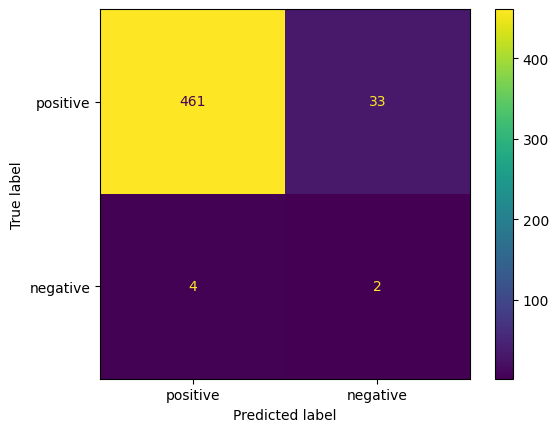

In [6]:
misclassified = confusion_matrix(docs['sentiment_original'], docs['sentiment_vader'], labels=["P", "N"])
ConfusionMatrixDisplay(misclassified, display_labels=["positive", "negative"]).plot()
report = classification_report(docs['sentiment_original'], docs['sentiment_vader'], labels=["P", "N"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
corr_coef = pearsonr(docs['score'], docs['compound'])

### Zapis wyników do plików

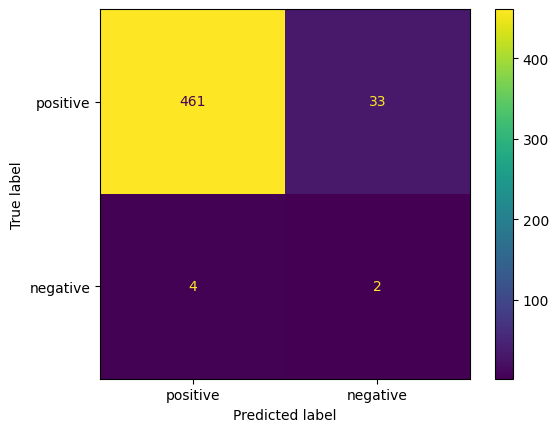

In [7]:
docs.to_csv("./sentiment_analysis_pl.csv", index=False, encoding="UTF-8")
report_df.to_csv("./sentiment_report_pl.csv", index=False, encoding="UTF-8")
ConfusionMatrixDisplay(misclassified, display_labels=["positive", "negative"]).plot().figure_.savefig("./confusion_matrix_pl.png")